In [1]:
# Check the versions of libraries
 
# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy 
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas 
print('pandas: {}'.format(pandas.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
# numba
import numba
print('numba: {}'.format(numba.__version__))
# pyod
from pyod import version
print('pyod: {}'.format(version.__version__))

Python: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
scipy: 1.2.1
numpy: 1.16.2
matplotlib: 3.0.3
pandas: 0.24.2
sklearn: 0.20.3
numba: 0.43.0
pyod: 0.6.8


In [2]:
# Load libraries
import numpy as np
from numpy.linalg import inv, det
import pandas as pd 

from pandas.plotting import scatter_matrix
#import matplotlib.pyplot as plt
#%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import random
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.models import Sequential
from tensorflow.python.framework import ops
ops.reset_default_graph()
#from keras import backend as K
from tensorflow.python.keras import backend as K
import time
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
#  USING ABOVE

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import seaborn as sns
from sklearn.model_selection import train_test_split

import scipy.stats as stats


from pyod.models.knn import KNN   # kNN detector
from pyod.utils.utility import standardizer


from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores


import os

import warnings
warnings.filterwarnings('once')
#warnings.filterwarnings('igbore')

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

In [3]:
# Load dataset
dfs = pd.read_csv(r'FinalProcessing_out97.csv', header = 0)


In [4]:
print("Number of observations:",len(dfs))
print("Number of normal transactions:",sum(dfs.cia==0))
print("Number of outliers:",sum(dfs.cia==1))
print("Ratio of outliers versus normal transaction:",sum(dfs.cia==1)/sum(dfs.cia==0))
#print("Dataset Shape:",dfs.shape)
dfs.head()

Number of observations: 4335
Number of normal transactions: 3361
Number of outliers: 974
Ratio of outliers versus normal transaction: 0.2897947039571556


,timestamp,cia,_exit,_llseek,accept4,bind,capset,clock_gettime,clone,close,...,socketpair,statfs64,tgkill,ugetrlimit,umount2,unlinkat,unshare,wait4,write,writev
0,1.553914e+09,0,0.0,0.0,0.0,0.0,0.0,14.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.553914e+09,0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.553914e+09,0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.553914e+09,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.553914e+09,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
y = dfs.cia.astype(float)
dfs = dfs.drop(columns = ["cia"])#@@@.astype(float)
dfs = dfs.drop(columns = ["timestamp"])#@@@.astype(float)

In [6]:
print(dfs.shape)

(4335, 95)


In [7]:
#################################################
#scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dfs = scaler.fit_transform(dfs)
################################################

In [8]:
from sklearn import preprocessing   
x = dfs
#x = dfs.drop(columns = ["cia"])
#x = preprocessing.scale(x, with_mean='True', with_std='False')
#y = dfs.cia
#print(y)
outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)
print("outliers_percentage: ",outliers_percentage,"%")


# Define nine outlier detection tools to be compared
#RandomState - train_test_split splits arrays or matrices into random train and test subsets. 
# That means that everytime you run it without specifying random_state, you will get a different result, this is expected behavior.
# On the other hand if you use random_state=some_number, then you can guarantee that the output of Run 1 will be equal to the output of Run 2,
random_state = np.random.RandomState(42)
print(x.shape)
print(y.shape)

# 60% data for training and 40% for testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=random_state)

 # standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

#print(X_train.shape[0])
data = np.array(X_train, dtype=float)
X_train = np.reshape(data, (data.shape[0],1,data.shape[1]))
data = np.array(X_test, dtype=float)
X_test = np.reshape(data, (data.shape[0],1,data.shape[1]))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print("Number of train outliers:",sum(y_train))
print("Number of test outliers:",sum(y_test))

outliers_percentage:  22.4683 %
(4335, 95)
(4335,)
(2167, 1, 95)
(2168, 1, 95)
(2167,)
(2168,)
Number of train outliers: 485.0
Number of test outliers: 489.0


In [9]:
def selectindex(num):
    return random.randint(0, num-1)

In [10]:
def mutate(child):
    for point in range(len(child)):
        if np.random.rand() < mutation_rate:
            if point == 0:
                child[point] = random.choice(epochs)
            elif point == 1:
                child[point] = random.choice(batch_size)
            elif point == 2 or point == 3:
                child[point] = random.choice(activations)
            else:
                child[point] = random.choice(optimizers)
    return child

In [11]:
def randomPopGenerator(pop_size):
    pop = []
    for i in range(pop_size):
        indv = []
        indv.append(random.choice(batch_size))  
        indv.append(random.choice(epochs))        
        indv.append(random.choice(neurons_number)) #hidden1
        indv.append(random.choice(neurons_number)) #hidden2
        indv.append(random.choice(neurons_number)) #hidden3
        indv.append(random.choice(loss))
        indv.append(random.choice(optimizers))
        pop.append(indv)
    return pop

In [12]:
def mutate(child):
    for point in range(len(child)):
        if np.random.rand() < mutation_rate:
            if point == 0:
                child[point] = random.choice(batch_size)
            elif point == 1:
                child[point] = random.choice(epochs)
            elif point == 2 or point == 3 or  point == 4 :
                child[point] = random.choice(neurons_number)
            elif point == 5:    
                child[point] = random.choice(loss)
            else:
                child[point] = random.choice(optimizers)
    return child

In [13]:
def crossover(indv1, indv2):
    child = []
    if np.random.rand() < cross_rate:
         for i in range(len(indv1)):        
            x = random.random()
            if(int(100 * x) < 50):
                child.append(indv1[i])
            else:
                child.append(indv2[i])
    return child

In [14]:
def Genetic_LSTM (pop_size, total_num_generations):    
    
    #print(" ---------------------  Generating Random Population  ----------------- ")
    pop = randomPopGenerator(pop_size)
    #print (pop)
    
    
    #print(" -------------------------  Lists for Analysis  ----------------------- ")
    bestF1 = []
    bestChromosome = []
    bestRecall = []
    bestPrecision = []    
    bestHistory = []  
    
    curr_pop = pop
    num_generation = 0
    gen_precision = []   # Generations
    gen_recall = []      # Generations
    gen_F1_score = []    # Generations
    gen_History = []     # Generations
        
    #print("-------------------------- Running GA + LSTM -------------------------- ")
    while(num_generation+1 <= total_num_generations): 
        

    
    # -----------------------  Training LSTM on current population  -------------------- #
        for chromosome in curr_pop:
            Precision_Score, Recall_Score, F1_Score, History = runLSTM(chromosome)
            #print(Precision_Score, Recall_Score, F1_Score)
            gen_precision.append(Precision_Score)
            gen_recall.append(Recall_Score)
            gen_F1_score.append(F1_Score)
            gen_History.append(History)
    
    
    # -- Constructing a 2D array as [Chromosome, AUC(Chromosome), Val_Accuracy(Chromosome), Val_Loss(Chromosome)] for Curr_pop -- #
        currPopwAcc = []
        for i in range(len(curr_pop)):
            currPopwAcc.append([curr_pop[i], gen_F1_score[i], gen_recall[i], gen_precision[i], gen_History[i]])
    
    
    # --- Sorting the 2D Array on the basis of F1_score, then recall, then precision --- #
        #####currPopwAcc = sorted(currPopwAcc, key = lambda x: x[4])
        currPopwAcc = sorted(currPopwAcc, key = lambda x: x[3])
        currPopwAcc = sorted(currPopwAcc, key = lambda x: x[2])
        currPopwAcc = sorted(currPopwAcc, key = lambda x: x[1])
    
    
    # ---------------  Calculating average f1 of curr_pop  --------------- #
        avg = sum(gen_F1_score)/len(gen_F1_score)
    
    
    # ----  Selecting chromosomes with f1 > Avg as fit for crossover  ---- #
        selection=[]
        for i in range(len(curr_pop)):
            if(currPopwAcc[-1-i][1]>=avg):
                selection.append(currPopwAcc[-1-i][0])
            
    
        
    # ------------  Crossover + Mutation from selected Parents  ----------- #
        next_pop = []
        if (len(curr_pop)>7):## was 5
            for i in range(7):## was 5
                next_pop.append(currPopwAcc[-1-i][0])
        else:
             for i in range(len(curr_pop)):
                next_pop.append(currPopwAcc[-1-i][0])
        
        
        
        while len(next_pop) < pop_size:
            idx1 = selectindex(len(selection))
            idx2 = selectindex(len(selection))
            if idx1!= idx2:
                offspring = crossover(selection[idx1], selection[idx2])
                mutate(offspring)
                if len(offspring) != 0:
                    next_pop.append(offspring)
    
    
    # -----------------------  Changing Generation  ----------------------- #
        curr_pop = next_pop
     
    
    # -----------------------  Updating Results Lists  -------------------- #    
        bestChromosome.append(currPopwAcc[-1][0])
        bestF1.append(currPopwAcc[-1][1])
        bestRecall = [currPopwAcc[-1][2]]
        bestPrecision = [currPopwAcc[-1][3]]        
        bestHistory.append(currPopwAcc[-1][4])
        print("\t" + str(num_generation+1) + ") Best F1 Score = " + str(bestF1[-1]), "\t# Recall=" + str(bestRecall[-1]), "\t# Precision  =" + str(bestPrecision[-1]), "\t# ")
        print("Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer]", bestChromosome[-1] , "#  ")
        #plt.plot(bestHistory[-1].history['loss'])
        #plt.plot(bestHistory[-1].history['val_loss'])
        #plt.title('model train vs validation loss')
        #plt.ylabel('loss')
        #plt.xlabel('epoch')
        #plt.legend(['train', 'validation'], loc='upper right')
        #plt.show()
      

        num_generation += 1
        gc.collect()
    print(bestF1)
    print(bestChromosome)
    return bestF1, bestChromosome


In [15]:
def runLSTM( chromosome):
    
    # ----  Spliting Independent and Dependent Variables, and, Test and Train Data  ----- #
    #X_train, X_test, y_train, y_test = test_train_split(data)
    ##n = data.shape[1] - 1
    

    model = Sequential()
    #print("")
    #print("-------------------------LSTM Buildibg Model --------------------------")
    layers = {'input': 1, 'hidden1': chromosome[2], 'hidden2': chromosome[3], 'hidden3': chromosome[4], 'output': 1}

    look_back = data.shape[1]    
    model.add(LSTM(16, input_shape=(1, look_back), return_sequences=True))
        
    #Dropout is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from 
    #activation and weight updates while training a network. This has the effect of reducing overfitting 
    #and improving model performance.
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers['hidden2'], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers['hidden3'], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))
    
    model.compile(loss=chromosome[5], optimizer=chromosome[6])
    
    
    #print("-------------------- Training LSTM ------------------------")
    #print( X_train, y_train, chromosome[0], chromosome[1], 0.05)
    history = model.fit( X_train, y_train, batch_size=chromosome[0], epochs=chromosome[1], validation_split=0.05, verbose = 0)
    #print("---------------------- Predicting -------------------------")
    predicted = model.predict(X_test)
    #print("Reshaping predicted")
    predicted = np.reshape(predicted, (predicted.size,))
    #print("Predicting shape", y_test)
    #print("Predicting shape", predicted.round())
    print("F1 Score:",round(metrics.f1_score(y_test, predicted.round(),average='macro'), ndigits=5),"Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer]",chromosome)
    Precision_Score = round(metrics.precision_score(y_test, predicted.round(),average='macro'), ndigits=5)
    Recall_Score = round(metrics.recall_score(y_test, predicted.round(),average='macro'), ndigits=5)
    F1_Score = round(metrics.f1_score(y_test, predicted.round(),average='macro'), ndigits=5)
    K.clear_session()
    #print(Precision_Score, Recall_Score, F1_Score)
    return Precision_Score, Recall_Score, F1_Score, history

Instructions for updating:
Colocations handled automatically by placer.


D:\Users\carlo\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


D:\Users\carlo\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\carlo\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score: 0.43644 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 15, 64, 128, 16, 'mean_absolute_error', 'sgd']
Instructions for updating:
Use tf.cast instead.
F1 Score: 0.89516 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 100, 8, 64, 64, 'mean_squared_error', 'Nadam']


D:\Users\carlo\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\Users\carlo\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 Score: 0.48611 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 32, 2, 8, 'mean_squared_logarithmic_error', 'sgd']
F1 Score: 0.43644 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 25, 16, 64, 128, 'mean_absolute_percentage_error', 'Adagrad']
F1 Score: 0.09626 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 1, 16, 64, 128, 'squared_hinge', 'Nadam']
F1 Score: 0.43644 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 10, 2, 8, 4, 'mean_absolute_percentage_error', 'Adadelta']
F1 Score: 0.18404 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 32, 32, 64, 'squared_hinge', 'sgd']
F1 Score: 0.0 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 10, 64, 64, 4, 'squared_hinge', 'RMSprop']
F1 Score: 0.88245 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 25, 2, 4, 2, 'mean_squared_error', 'RMSprop']
F1 Score: 0.0 Chromosome [Batch Si

F1 Score: 0.0 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 2, 8, 8, 'hinge', 'Adadelta']
F1 Score: 0.18404 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 32, 32, 64, 'squared_hinge', 'sgd']
F1 Score: 0.0 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 2, 64, 8, 'hinge', 'Adagrad']
F1 Score: 0.52991 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 32, 64, 4, 'mean_squared_logarithmic_error', 'sgd']
F1 Score: 0.88555 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 2, 2, 8, 'mean_squared_logarithmic_error', 'Adagrad']
	6) Best F1 Score = 0.89516 	# Recall=0.91101 	# Precision  =0.88196 	# 
Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 2, 64, 8, 'mean_absolute_percentage_error', 'Adagrad'] #  
F1 Score: 0.43644 Chromosome [Batch Size,epochs,layer1,layer2,layer3,loss,optimizer] [1, 50, 2, 64, 8, 'mean_absolute_percentage_error

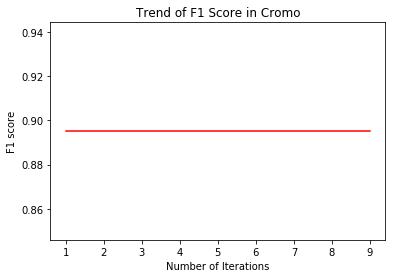

In [16]:
cross_rate = 0.8
mutation_rate = 0.03
# --------------------------------------------  Input Variables --------------------------------------------------- #
#activations = ['linear','sigmoid', 'softmax', 'tanh', 'relu', 'elu', 'selu', 'softplus', 'softsign', 'hard_sigmoid']

loss = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','mean_squared_logarithmic_error','squared_hinge','hinge','categorical_hinge','logcosh']
optimizers = ['Nadam', 'Adamax', 'Adam', 'sgd', 'Adadelta', 'Adagrad', 'RMSprop']
neurons_number =[2, 4, 8, 16, 32, 64, 128]
epochs = [1, 5, 10, 15, 25, 50, 100]
batch_size = [1]
#batch_size = [1,  4, 16, 64, 500, 1000, 3000]
#epochs = [1]
#loss = ['mean_squared_error','mean_absolute_error']
#optimizers = [ 'Adam']
#neurons_number =[2, 4, 8, 16, 32, 64, 128]
#batch_size = [1,  4, 16, 64, 500, 1000, 3000]
#epochs = [1]
#epochs = [1]

population_size = 10 #number of interactions to choose
num_generations = 9  #number of crossing gene and mutations between generations
gene_length = 7      #number of itens to modify

tic = time.time()
best_f1, best_cromo = Genetic_LSTM( population_size, num_generations)


plt.figure(0) 
plt.title("Trend of F1 Score in Cromo")
plt.plot(range(1, len(best_f1)+1), best_f1, color = 'red')
plt.xticks(range(1, (len(best_f1)+1)))
plt.xlabel("Number of Iterations")
plt.ylabel("F1 score")
plt.show()
K.clear_session()

In [17]:
print("seconds: ", time.time() - tic, " ---------------")

seconds:  105737.6989364624  ---------------


In [18]:
print(predicted)

NameError: name 'predicted' is not defined